<a href="https://colab.research.google.com/github/prevencao/trading/blob/master/stockPrice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://www.thepythoncode.com/article/stock-price-prediction-in-python-using-tensorflow-2-and-keras

##**Como prever os preços das ações em Python usando TensorFlow 2 e Keras**

In [ ]:
!pip3 install tensorflow pandas numpy matplotlib yahoo_fin sklearn

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from yahoo_fin import stock_info as si
from collections import deque

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import os
import random

Warning - Certain functionality 
             requires requests_html, which is not installed.
             
             Install using: 
             pip install requests_html
             
             After installation, you may have to restart your Python session.


In [ ]:
'''definir semente, para que possamos obter os 
mesmos resultados depois de executar novamente 
várias vezes'''
np.random.seed(314)
tf.random.set_seed(314)
random.seed(314)

## Preparando o DataSet

In [ ]:
def load_data(ticker, n_steps=50, scale=True, shuffle=True, lookup_step=1, 
                test_size=0.2, feature_columns=['adjclose', 'volume', 'open', 'high', 'low']):
    # see if ticker is already a loaded stock from yahoo finance
    if isinstance(ticker, str):
        # load it from yahoo_fin library
        df = si.get_data(ticker)
    elif isinstance(ticker, pd.DataFrame):
        # already loaded, use it directly
        df = ticker
    # this will contain all the elements we want to return from this function
    result = {}
    # we will also return the original dataframe itself
    result['df'] = df.copy()
    # make sure that the passed feature_columns exist in the dataframe
    for col in feature_columns:
        assert col in df.columns, f"'{col}' does not exist in the dataframe."
    if scale:
        column_scaler = {}
        # scale the data (prices) from 0 to 1
        for column in feature_columns:
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
            column_scaler[column] = scaler

        # add the MinMaxScaler instances to the result returned
        result["column_scaler"] = column_scaler
    # add the target column (label) by shifting by `lookup_step`
    df['future'] = df['adjclose'].shift(-lookup_step)
    # last `lookup_step` columns contains NaN in future column
    # get them before droping NaNs
    last_sequence = np.array(df[feature_columns].tail(lookup_step))
    # drop NaNs
    df.dropna(inplace=True)
    sequence_data = []
    sequences = deque(maxlen=n_steps)
    for entry, target in zip(df[feature_columns].values, df['future'].values):
        sequences.append(entry)
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])
    # get the last sequence by appending the last `n_step` sequence with `lookup_step` sequence
    # for instance, if n_steps=50 and lookup_step=10, last_sequence should be of 59 (that is 50+10-1) length
    # this last_sequence will be used to predict in future dates that are not available in the dataset
    last_sequence = list(sequences) + list(last_sequence)
    # shift the last sequence by -1
    last_sequence = np.array(pd.DataFrame(last_sequence).shift(-1).dropna())
    # add to result
    result['last_sequence'] = last_sequence
    # construct the X's and y's
    X, y = [], []
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)
    # convert to numpy arrays
    X = np.array(X)
    y = np.array(y)
    # reshape X to fit the neural network
    X = X.reshape((X.shape[0], X.shape[2], X.shape[1]))
    # split the dataset
    result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y, test_size=test_size, shuffle=shuffle)
    # return the result
    return result

## Criando o Modelo


Agora que temos uma função adequada para carregar e preparar o conjunto de 

dados, precisamos de outra função central para construir nosso modelo







In [ ]:
def create_model(sequence_length, units=256, cell=LSTM, n_layers=2, dropout=0.3,
                loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False):
    model = Sequential()
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), input_shape=(None, sequence_length)))
            else:
                model.add(cell(units, return_sequences=True, input_shape=(None, sequence_length)))
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
            else:
                model.add(cell(units, return_sequences=False))
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
            else:
                model.add(cell(units, return_sequences=True))
        # add dropout after each layer
        model.add(Dropout(dropout))
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    return model

## Treinando o Modelo

In [ ]:
# Window size or the sequence length
N_STEPS = 100
# Lookup step, 1 is the next day
LOOKUP_STEP = 1
# test ratio size, 0.2 is 20%
TEST_SIZE = 0.2
# features to use
FEATURE_COLUMNS = ["adjclose", "volume", "open", "high", "low"]
# date now
date_now = time.strftime("%Y-%m-%d")
### model parameters
N_LAYERS = 3
# LSTM cell
CELL = LSTM
# 256 LSTM neurons
UNITS = 256
# 40% dropout
DROPOUT = 0.4
# whether to use bidirectional RNNs
BIDIRECTIONAL = False
### training parameters
# mean absolute error loss
# LOSS = "mae"
# huber loss
LOSS = "huber_loss"
OPTIMIZER = "adam"
BATCH_SIZE = 64
EPOCHS = 400
# Apple stock market
ticker = "AAPL"
ticker_data_filename = os.path.join("data", f"{ticker}_{date_now}.csv")
# model name to save, making it as unique as possible based on parameters
model_name = f"{date_now}_{ticker}-{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"
if BIDIRECTIONAL:
  model_name += "-b"

In [ ]:
# cria essas pastas se elas não existirem
if not os.path.isdir("results"):
    os.mkdir("results")
if not os.path.isdir("logs"):
    os.mkdir("logs")
if not os.path.isdir("data"):
    os.mkdir("data")

In [ ]:
# carrega os dados
data = load_data(ticker, N_STEPS, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, feature_columns=FEATURE_COLUMNS)

# salva o dataframe
data["df"].to_csv(ticker_data_filename)

# constroi o modelo
model = create_model(N_STEPS, loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)

# alguns retornos do TensorFlow
checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))

history = model.fit(data["X_train"], data["y_train"],
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer, tensorboard],
                    verbose=1)

model.save(os.path.join("results", model_name) + ".h5")

Epoch 1/400
  1/124 [..............................] - ETA: 0s - loss: 0.0111 - mean_absolute_error: 0.0670WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
121/124 [============================>.] - ETA: 0s - loss: 6.5729e-04 - mean_absolute_error: 0.0162
Epoch 00001: val_loss improved from inf to 0.00024, saving model to results/2020-08-17_AAPL-huber_loss-adam-LSTM-seq-100-step-1-layers-3-units-256.h5
124/124 [==============================] - 2s 16ms/step - loss: 6.4804e-04 - mean_absolute_error: 0.0161 - val_loss: 2.3731e-04 - val_mean_absolute_error: 0.0079
Epoch 2/400
119/124 [===========================>..] - ETA: 0s - loss: 3.9408e-04 - mean_absolute_error: 0.0127
Epoch 00002: val_loss did not improve from 0.00024
124/124 [==============================]

Após o término do treinamento (ou durante o treinamento), 

tente executar o tensorboard usando este comando

In [ ]:
tensorboard --logdir="logs"

SyntaxError: ignored

Testando o Modelo

In [ ]:
data = load_data(ticker, N_STEPS, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE,
                feature_columns=FEATURE_COLUMNS, shuffle=False)

# constroi o modelo
model = create_model(N_STEPS, loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS,
                    dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)

model_path = os.path.join("results", model_name) + ".h5"
model.load_weights(model_path)

In [ ]:
# avaliar o modfelo
mse, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)
# calcular o erro absoluto médio (escala inversa)
mean_absolute_error = data["column_scaler"]["adjclose"].inverse_transform([[mae]])[0][0]
print("Mean Absolute Error:", mean_absolute_error)

Mean Absolute Error: 2.720011511418901


Nada mal, em média, o preço previsto está apenas longe do preço real em 4,42 $.

Tudo bem, vamos tentar prever o preço futuro do Apple Stock Market

# Agora vamos testar nosso modelo

In [ ]:
'''# validado o modelo
mse, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)
# calcular o erro absoluto médio (escala inversa)
mean_absolute_error = data["column_scaler"]["adjclose"].inverse_transform([[mae]])[0][0]
print("Mean Absolute Error:", mean_absolute_error)'''

Mean Absolute Error: 2.720011511418901


Tentando prever o preço futuro do mercado de ações da Apple:


In [ ]:
def predict(model, data, classification=False):
    # retrieve the last sequence from data
    last_sequence = data["last_sequence"][:N_STEPS]
    # retrieve the column scalers
    column_scaler = data["column_scaler"]
    # reshape the last sequence
    last_sequence = last_sequence.reshape((last_sequence.shape[1], last_sequence.shape[0]))
    # expand dimension
    last_sequence = np.expand_dims(last_sequence, axis=0)
    # get the prediction (scaled from 0 to 1)
    prediction = model.predict(last_sequence)
    # get the price (by inverting the scaling)
    predicted_price = column_scaler["adjclose"].inverse_transform(prediction)[0][0]
    return predicted_price

Esta função usa a variável last_sequence que salvamos na função load_data (), 

que é basicamente a última sequência de preços, usamos para prever o próximo preço, vamos chamar isso

In [ ]:
# prever o preço futuro
future_price = predict(model, data)
print(f"Future price after {LOOKUP_STEP} days is {future_price:.2f}$")

Future price after 1 days is 455.27$


Soa interessante ! O último preço foi de 298,45.  a modelo diz que no dia seguinte será  de 455.27 $. 

O modelo acabou de usar 50 dias de recursos para conseguir esse valor, vamos traçar os preços e ver

In [ ]:
def plot_graph(model, data):
    y_test = data["y_test"]
    X_test = data["X_test"]
    y_pred = model.predict(X_test)
    y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
    y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    # últimos 200 dias, fique à vontade para editar isso
    plt.title('AAPL')
    plt.plot(y_test[-200:], c='b')
    plt.plot(y_pred[-200:], c='r')
    plt.xlabel("Days")
    plt.ylabel("Price")
    plt.legend(["Actual Price", "Predicted Price"])
    plt.show()

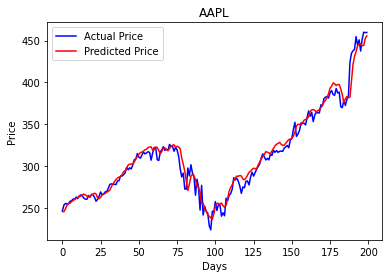

In [ ]:
plot_graph(model, data)

In [ ]:
print(f"Future price after {LOOKUP_STEP} 
      days is {future_price:.2f}$")

Future price after 1 days is 455.27$


In [ ]:
def get_accuracy(model, data):
    y_test = data["y_test"]
    X_test = data["X_test"]
    y_pred = model.predict(X_test)
    y_test = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(np.expand_dims(y_test, axis=0)))
    y_pred = np.squeeze(data["column_scaler"]["adjclose"].inverse_transform(y_pred))
    y_pred = list(map(lambda current, future: int(float(future) > float(current)), y_test[:-LOOKUP_STEP], y_pred[LOOKUP_STEP:]))
    y_test = list(map(lambda current, future: int(float(future) > float(current)), y_test[:-LOOKUP_STEP], y_test[LOOKUP_STEP:]))
    return accuracy_score(y_test, y_pred)

Agora vamos chamar a função

In [ ]:
print(str(LOOKUP_STEP) + ":", "Accuracy Score:", get_accuracy(model, data))

1: Accuracy Score: 0.5323232323232323


Conclusão

Tudo bem, é isso para este tutorial, você pode ajustar os parâmetros e ver como pode melhorar o desempenho do modelo, tentar treinar em mais épocas, digamos 500 ou mais, aumentar ou diminuir o BATCH_SIZE e ver se muda para melhor, ou experimente N_STEPS e LOOKUP_STEPS e veja qual combinação funciona melhor.

Você também pode alterar os parâmetros do modelo, como aumentar o número de camadas ou o número de unidades LSTM, ou mesmo experimentar a célula GRU em vez de LSTM.

Observe que existem outros recursos e indicadores a serem usados, a fim de melhorar a previsão, muitas vezes é conhecido o uso de algumas outras informações como recursos, como indicadores técnicos, a inovação do produto da empresa, taxa de juros, taxa de câmbio, políticas públicas, o notícias da web e financeiras e até mesmo o número de funcionários!

Eu encorajo você a mudar a arquitetura do modelo, tentar usar modelos CNNs ou Seq2Seq, ou mesmo adicionar LSTMs bidirecionais a este modelo existente, veja se você pode melhorá-lo!

Além disso, use diferentes mercados de ações, verifique a página do [Yahoo Finance](https://finance.yahoo.com/) e veja qual você realmente deseja!

Se você não estiver usando um notebook ou um shell interativo, dividi o código em diferentes arquivos Python, cada um para seu propósito, verifique  [aqui](https://www.thepythoncode.com/code/stock-price-prediction-in-python-using-tensorflow-2-and-keras).